# Workload and AHT see the largest difference in forecast accuracy on the metric Mean Absolute Error (MAE) when comparing the old model to prophet.

The new Prophet model workload forecasts for RIS (MAE ~ 46 hours) compared to Old Model (MAE ~ 439 hours) have been closer to the actual handle times recieved by an average of 393 hours daily for the period of January 1st to January 18th, 2021.

This is a period of 10 days.

# Define methods for producing predictions and scoring

********************************************************************************
RIS_aht_vol.csv
********************************************************************************


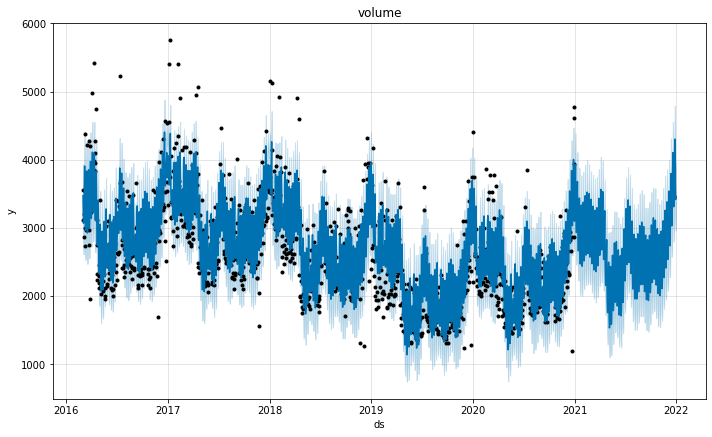

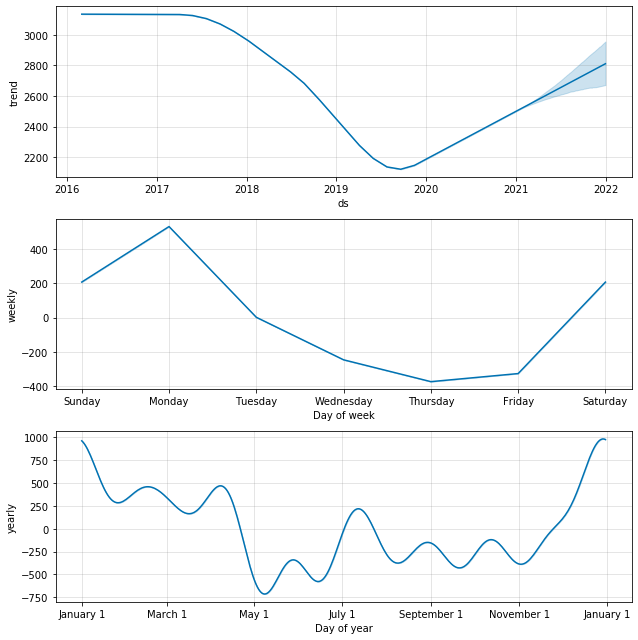

volume


,ds,yhat_lower,yhat,yhat_upper,volume,volume_forecast,error_prophet,error_forecast,diff
0,2021-01-04,3470.780485,3929.024786,4392.861483,7230.0,4417.0,3301.0,2813.0,-488.0
1,2021-01-05,2887.983291,3373.118875,3832.818497,5657.0,3471.0,2284.0,2186.0,-98.0
2,2021-01-06,2602.871067,3094.300789,3549.159299,4899.0,3226.0,1805.0,1673.0,-132.0
3,2021-01-07,2459.985089,2933.150670,3377.692922,5169.0,3127.0,2236.0,2042.0,-194.0
4,2021-01-08,2498.387057,2943.742258,3393.930097,4853.0,3146.0,1909.0,1707.0,-202.0
5,2021-01-11,3259.400253,3682.348823,4111.478600,5912.0,5462.0,2230.0,450.0,-1780.0
6,2021-01-12,2691.375113,3115.332166,3539.209360,5319.0,4403.0,2204.0,916.0,-1288.0
7,2021-01-13,2373.833614,2829.354284,3291.245160,4354.0,4019.0,1525.0,335.0,-1190.0
8,2021-01-14,2240.937084,2665.005196,3121.244494,4115.0,3883.0,1450.0,232.0,-1218.0
9,2021-01-15,2227.426729,2676.294694,3137.209024,3928.0,3959.0,1252.0,31.0,-1221.0


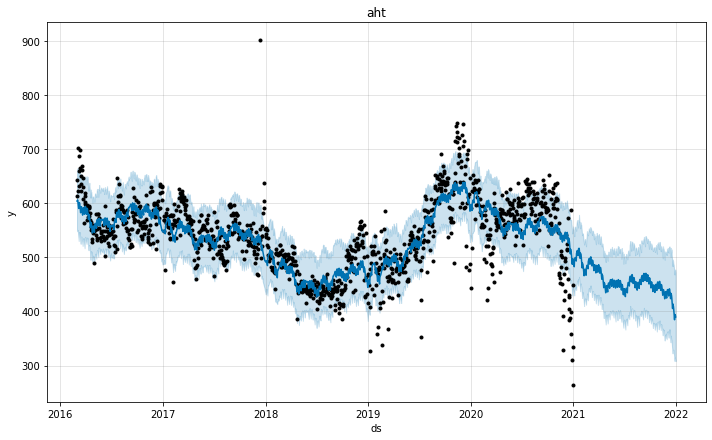

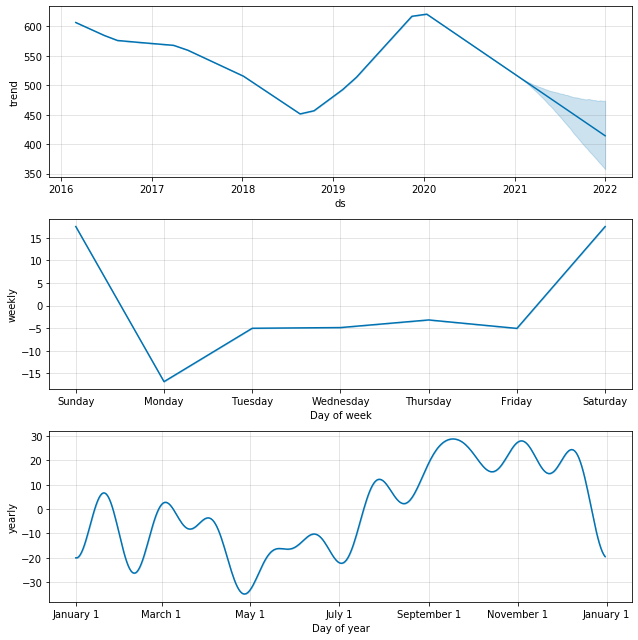

aht


,ds,yhat_lower,yhat,yhat_upper,aht,aht_forecast,error_prophet,error_forecast,diff
0,2021-01-04,429.415782,482.550840,538.986609,180.961826,756.028526,302.0,575.0,273.0
1,2021-01-05,438.662525,495.181385,550.050305,283.609157,747.890810,212.0,464.0,252.0
2,2021-01-06,440.192794,496.458001,554.161663,275.490304,745.205518,221.0,470.0,249.0
3,2021-01-07,443.156447,499.527511,556.801240,278.565487,743.086345,221.0,465.0,244.0
4,2021-01-08,444.812007,499.253566,556.157619,313.355450,744.085188,186.0,431.0,245.0
5,2021-01-11,439.750646,493.009173,548.767546,259.203146,827.969059,234.0,569.0,335.0
6,2021-01-12,449.705685,506.721367,561.552543,302.175033,819.094935,205.0,517.0,312.0
7,2021-01-13,451.089654,508.707931,565.930046,365.205788,813.937795,144.0,449.0,305.0
8,2021-01-14,454.562952,512.099447,568.446371,377.676063,809.057687,134.0,431.0,297.0
9,2021-01-15,457.246817,511.752804,565.177941,361.590886,806.025006,150.0,444.0,294.0


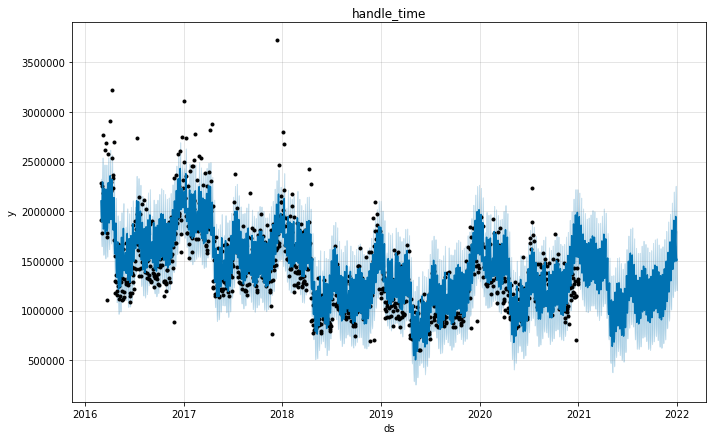

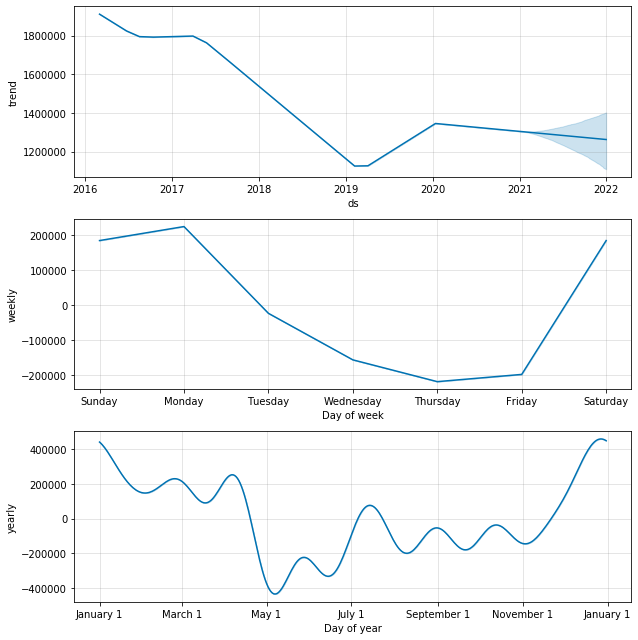

handle_time


,ds,yhat_lower,yhat,yhat_upper,handle_time,handle_time_forecast,error_prophet,error_forecast,diff
0,2021-01-04,1.716077e+06,1.944634e+06,2.187750e+06,1308354.0,3339378.0,636280.0,2031024.0,1394744.0
1,2021-01-05,1.446467e+06,1.686875e+06,1.957609e+06,1604377.0,2595929.0,82498.0,991552.0,909054.0
2,2021-01-06,1.285701e+06,1.542970e+06,1.797770e+06,1349627.0,2404033.0,193343.0,1054406.0,861063.0
3,2021-01-07,1.216571e+06,1.468935e+06,1.731665e+06,1439905.0,2323631.0,29030.0,883726.0,854696.0
4,2021-01-08,1.234672e+06,1.477110e+06,1.714746e+06,1520714.0,2340892.0,43604.0,820178.0,776574.0
5,2021-01-11,1.610769e+06,1.859197e+06,2.136578e+06,1532409.0,4522367.0,326788.0,2989958.0,2663170.0
6,2021-01-12,1.355980e+06,1.598743e+06,1.865830e+06,1607269.0,3606475.0,8526.0,1999206.0,1990680.0
7,2021-01-13,1.201309e+06,1.452945e+06,1.725461e+06,1590106.0,3271216.0,137161.0,1681110.0,1543949.0
8,2021-01-14,1.135425e+06,1.377786e+06,1.639120e+06,1554137.0,3141571.0,176351.0,1587434.0,1411083.0
9,2021-01-15,1.111333e+06,1.385568e+06,1.634163e+06,1420329.0,3191053.0,34761.0,1770724.0,1735963.0


In [38]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
import datetime

def load_data(path):
    """
    using a path to a bu dataset return the dataframe
    """
    # create a pandas dataframe object
    df = pd.read_csv('../data/'+path, index_col=0,
                     parse_dates=['date'])

    # create column for aht
    df['aht'] = df['handle_time']/df['volume']
    df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']


    df.index = df['date']
    return df

def remove_holidays(df, path='../data/holidays.csv'):
    """
    take in a holidays csv of dates and return
    a filtered dataframe
    """
    
    holidays = pd.read_csv(path)
    
    if 'ds' not in df.columns:
        date_marker = 'date'
    else:
        date_marker = 'ds'
    
    return df[(~df[date_marker].dt.weekday.isin([5,6])) & (~df[date_marker].isin(holidays.iloc[:,0].tolist()))]

def clean_training_data(df, holidays=False):
    """
    take in a dataframe and return a filtered dataframe
    """
    
    # remove holidays and weekends
    if not holidays:
        df = remove_holidays(df)
    
    ## remove zeros
    df = df[df['handle_time'] > 10000]
    
    # remove nulls
    df = df[df['aht'].notnull()]

    return df

def create_training_data(df, metric, start='2016-01-01', end='2020-06-01'):
    """
    takes in a dataframe and returns a filtered dataframe
    """
    
    df = df[(df['date'] >= start) & (df['date'] < end)]
    
    df = df[[metric]]
    df = df.reset_index()
    df.columns = ['ds', 'y']
    return df

def train_model(df):
    """
    takes in a dataframe with 2 cols
    'ds' and 'y' and returns a prediction
    """
    # create default prophet model
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    m.fit(df)
    
    return m


def get_validation_data(df, end_training='2020-11-01', end_testing='2021-01-18'):
    """
    take in a dataframe and return a dataframe filtered after the end of training
    """
    df = remove_holidays(df)
    
    df = df[(df['date'] > end_training) & (df['date'] < end_testing)]
    
    return df



def get_accuracy(df2,forecast, kpi='handle_time'):
    """
    take in 2 dataframes df2 with original predictions and forecast with
    new predictions and return a dataframe of the MAE for each model and
    the difference between old model and prophet
    negative values indicate old model has less error.
    """
    mae1 = mean_absolute_error(df2[kpi], df2[kpi+'_forecast'])
    mae2 = mean_absolute_error(df2[kpi], forecast['yhat'])
    diff = mae1- mae2
    return pd.DataFrame(index=['old model', 'prophet', 'difference'], 
                 data=[int(mae1), int(mae2), int(diff)],
                 columns=['MAE'])

def get_performance(data, fields, start, end):
    """
    take in data as a list of csv from each business unit
    fields are the kpis being predicted
    start and end is the start date and end date of testing
    
    TODO
        setup model diagnostics
        https://facebook.github.io/prophet/docs/diagnostics.html
    """
    
    # load a dictionary with dates for starting training
    date_dict = {'BRO-Complex_aht_vol.csv':'2018-10-01', 'BRO_aht_vol.csv': '2018-11-01', 
    'CS-Alaska_aht_vol.csv':'2016-01-01', 'CS-John-Hancock_aht_vol.csv':'2019-12-01', 
    'CS-Maryland_aht_vol.csv': '2017-11-01', 'CS-National_aht_vol.csv':'2016-11-01', 
    'PSG_aht_vol.csv':'2019-11-01', 'RCS-PHONES_aht_vol.csv':'2018-11-01', 
    'RIS_aht_vol.csv':'2016-03-01', 'WISE-Contractual_aht_vol.csv':'2016-11-01'}
    
    for b in data:
        # create a list for the scores of each kpi
        a = []
        print('*'*80)
        print(b)
        print('*'*80)
        for k in fields:
            bu = b
            kpi = k
            start_train = date_dict[b]
            start_test = start
            end_test = end

            df = load_data(bu)
            
#             if k == 'handle_time':
#                 df[k] /= 3600
            df = clean_training_data(df)
            
            df2 = get_validation_data(df, end_training=start_test)

            df = create_training_data(df, kpi, start=start_train, end=start_test)

            m = train_model(df)

            future = m.make_future_dataframe(periods=365)
            future = remove_holidays(future)
            forecast = m.predict(future)
            
            fig1 = m.plot(forecast)
            plt.title(k)
            fig2 = m.plot_components(forecast)
            plt.show()

            f = forecast[(forecast['ds'] > start_test) & (forecast['ds'] < end_test)]
            
            f = f.reset_index(drop=True)
            df2 = df2.reset_index(drop=True)

            write_f = f[['ds','yhat_lower', 'yhat', 'yhat_upper']]
            
            write_f = pd.concat([write_f, df2[[k,k+'_forecast']]], 1)
            write_f['error_prophet'] = (write_f['yhat'] - write_f[k]).abs().round()
            write_f['error_forecast'] = (write_f[k+'_forecast'] - write_f[k]).abs().round()
            write_f['diff'] = write_f['error_forecast'] - write_f['error_prophet']
            
            write_f.to_csv('../preds/'+k+'_'+b[:6]+'.csv')

            print(k)
            display(write_f)

            accuracy = get_accuracy(df2, f, kpi=kpi)
            a.append(accuracy)

        diff = pd.concat([a[0], a[1], a[2]], axis=1)
        diff.columns = ['volume', 'aht', 'handle_time']
        return m, diff

data = ['BRO_aht_vol.csv',
 'WISE-Contractual_aht_vol.csv',
 'CS-National_aht_vol.csv',
 'CS-Alaska_aht_vol.csv',
 'RIS_aht_vol.csv',
 'PSG_aht_vol.csv',
 'BRO-Complex_aht_vol.csv',
 'RCS-PHONES_aht_vol.csv',
 'CS-Maryland_aht_vol.csv',
 'CS-John-Hancock_aht_vol.csv']

data = ['RIS_aht_vol.csv']
m, diff = get_performance(data, ['volume', 'aht','handle_time'], '2021-01-01', '2021-01-18')

In [36]:
# run method for any business unit, kpi, and start and end date of testing
# get_performance(['WISE-Contractual_aht_vol.csv'], ['volume', 'aht','handle_time'], '2021-01-01', '2021-01-18')

In [37]:
diff['handle_time'] /= 3600
diff.rename(columns={'handle_time': 'workload (hours)'}, inplace=True)
print('Mean Absolute Error')

display(diff)

Mean Absolute Error


,volume,aht,workload (hours)
old model,1238,481,439.147500
prophet,2019,200,46.342778
difference,-780,280,392.804722


In [41]:
pd.DataFrame({'volume': [1238,2019,-780],
             'aht': [481,200,280],
             'workload (hours)': [439.1475, 46.342778,392.804722]}, index=['old model'])

,volume,aht,workload (hours)
0,1238,481,439.147500
1,2019,200,46.342778
2,-780,280,392.804722
